<a href="https://colab.research.google.com/github/uuuno/pytorch_tutorial/blob/master/1_4_TrainClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train an image classifier
1. CIFAR10のロード
2. CNNの定義
3. Loss関数の定義
4. 学習
5. テストによる評価

## 1. CIFAR10のロード

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

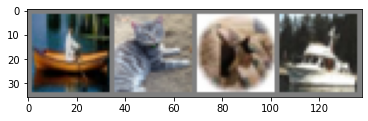

 ship   cat   cat  ship


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

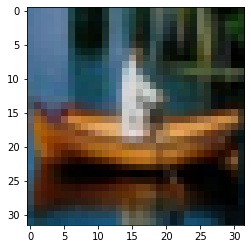

torch.Size([3, 32, 32])


In [6]:
imshow(images[0])
print(images[0].shape)

## 2. CNNの定義

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Lossの定義

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. 学習

In [9]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

[1,  2000] loss: 2.190
[1,  4000] loss: 1.843
[1,  6000] loss: 1.671
[1,  8000] loss: 1.565
[1, 10000] loss: 1.504
[1, 12000] loss: 1.453


KeyboardInterrupt: ignored

In [35]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. テスト

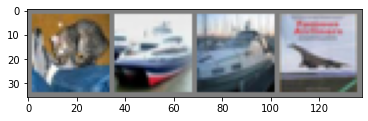

GroundTruth:    cat  ship  ship plane


In [36]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [37]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

In [39]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car plane


In [40]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 77 %
Accuracy of  bird : 44 %
Accuracy of   cat : 45 %
Accuracy of  deer : 36 %
Accuracy of   dog : 41 %
Accuracy of  frog : 66 %
Accuracy of horse : 69 %
Accuracy of  ship : 64 %
Accuracy of truck : 68 %


## GPU上での学習

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0
